In [2]:

import xarray as xr


ds_sat = xr.open_dataset('LGMR_data/ds_sat_flipped.nc')

import pandas as pd
df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
df_obl = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\obl.csv")

df = pd.DataFrame({
    'Time': ds_sat['age'].values,
    'X': df_pre['pre'].values,
    'Y': ds_sat['sat'].isel(lat=80).isel(lon=0).values
})

ds_sat

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

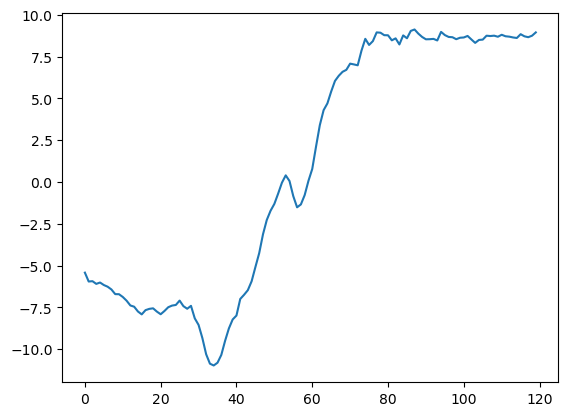

In [9]:
# plot any sat from the ds_sat

import matplotlib.pyplot as plt
import numpy as np

plt.plot(ds_sat['sat'].isel(lat=80).isel(lon=0).values)

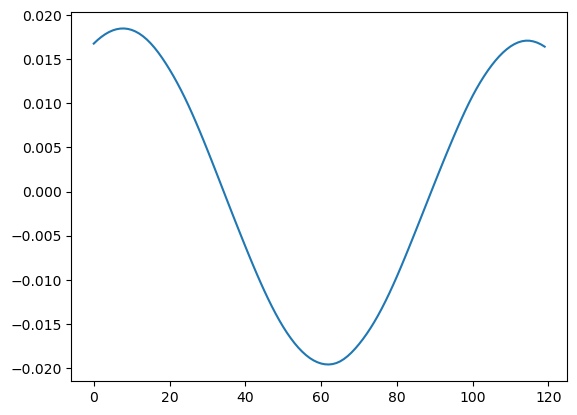

In [10]:
# plot df_pre
plt.plot(df_pre['pre'].values)

# print(df_pre['pre'].values)

In [7]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension


nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # keep track of the ages

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)

results_list = []  # will be a list of (ilat, ilon, E_axis, Tau_axis, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=10,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # Axis values for plotting
    E_axis = np.arange(1, 6)     # E = 1..5
    Tau_axis = np.arange(1, 11)  # tau = 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# Compute global min and max for all RhoMatrix values
# ---------------------------------------------------------------------
global_min = min(np.min(RhoMatrix) for _, _, _, _, RhoMatrix in results_list)
global_max = max(np.max(RhoMatrix) for _, _, _, _, RhoMatrix in results_list)

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results using Plotly subplots
# ---------------------------------------------------------------------

# Create subplot titles using true latitude and longitude values
subplot_titles = [
    f"lat={ds_sat['lat'].values[r[0]]:.2f}, lon={ds_sat['lon'].values[r[1]]:.2f}"
    for r in results_list
]

# Create a 2x5 grid of 3D subplots with adjusted spacing
fig = make_subplots(
    rows=2, cols=5,
    specs=[[{"type": "surface"}]*5, [{"type": "surface"}]*5],
    subplot_titles=subplot_titles,
    horizontal_spacing=0.03,  # reduce horizontal spacing
    vertical_spacing=0.1      # reduce vertical spacing
)

# Add each surface plot trace to its respective subplot
for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):
    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')
    row = (i // 5) + 1
    col = (i % 5) + 1

    # For a common colorbar, all surfaces use the same color range.
    # We enable the colorbar (showscale=True) only for the first trace.
    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho values
        colorscale="Viridis",
        cmin=global_min,
        cmax=global_max,
        showscale=True if i == 0 else False,
        # Customize the colorbar for the first subplot
        colorbar=dict(
            title="rho",
            titleside="right",
            x=1.02,  
            # adjust the shrink ratio to make the colorbar shorter
            len=0.3
        ) if i == 0 else None
    )

    fig.add_trace(surf, row=row, col=col)

# Update overall layout with adjusted margins for better label visibility
fig.update_layout(
    height=800,
    width=1400,
    margin=dict(l=50, r=50, t=80, b=50),
)

# ---------------------------------------------------------------------
# 3. Adjust the viewing angle (camera) for each subplot
# ---------------------------------------------------------------------
# Loop over each subplot scene and set the camera view.
# Note: The first scene is named 'scene', and subsequent ones as 'scene2', 'scene3', etc.
for i in range(1, len(results_list)+1):
    scene_id = f'scene{i}' if i > 1 else 'scene'
    fig.layout[scene_id].update(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho",
        camera=dict(
            eye=dict(x=1, y=2, z=3)  
        )
    )

fig.show()


In [ ]:
# fig.write_image("surface_plots.png", width=1400, height=800, scale=3)
fig.write_image("surface_plots.svg", width=1400, height=800)

# test for obl

In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension



nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # keep track of the ages

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)

results_list = []  # will be a list of (ilat, ilon, E_axis, Tau_axis, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "obl": df_obl['obl'].values,  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="obl",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=0,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # Axis values for plotting
    E_axis = np.arange(1, 6)     # E = 1..5
    Tau_axis = np.arange(1, 11)  # tau = 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# Compute global min and max for all RhoMatrix values
# ---------------------------------------------------------------------
global_min = min(np.min(RhoMatrix) for _, _, _, _, RhoMatrix in results_list)
global_max = max(np.max(RhoMatrix) for _, _, _, _, RhoMatrix in results_list)

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results using Plotly subplots
# ---------------------------------------------------------------------

# Create subplot titles using true latitude and longitude values
subplot_titles = [
    f"lat={ds_sat['lat'].values[r[0]]:.2f}, lon={ds_sat['lon'].values[r[1]]:.2f}"
    for r in results_list
]

# Create a 2x5 grid of 3D subplots with adjusted spacing
fig = make_subplots(
    rows=2, cols=5,
    specs=[[{"type": "surface"}]*5, [{"type": "surface"}]*5],
    subplot_titles=subplot_titles,
    horizontal_spacing=0.03,  # reduce horizontal spacing
    vertical_spacing=0.1      # reduce vertical spacing
)

# Add each surface plot trace to its respective subplot
for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):
    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')
    row = (i // 5) + 1
    col = (i % 5) + 1

    # For a common colorbar, all surfaces use the same color range.
    # We enable the colorbar (showscale=True) only for the first trace.
    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho values
        colorscale="Viridis",
        cmin=global_min,
        cmax=global_max,
        showscale=True if i == 0 else False,
        # Customize the colorbar for the first subplot
        colorbar=dict(
            title="rho",
            titleside="right",
            x=1.02,  
            # adjust the shrink ratio to make the colorbar shorter
            len=0.3
        ) if i == 0 else None
    )

    fig.add_trace(surf, row=row, col=col)

# Update overall layout with adjusted margins for better label visibility
fig.update_layout(
    height=800,
    width=1400,
    margin=dict(l=50, r=50, t=80, b=50),
)

# ---------------------------------------------------------------------
# 3. Adjust the viewing angle (camera) for each subplot
# ---------------------------------------------------------------------
# Loop over each subplot scene and set the camera view.
# Note: The first scene is named 'scene', and subsequent ones as 'scene2', 'scene3', etc.
for i in range(1, len(results_list)+1):
    scene_id = f'scene{i}' if i > 1 else 'scene'
    fig.layout[scene_id].update(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho",
        camera=dict(
            eye=dict(x=1, y=2, z=3)  
        )
    )

fig.show()
